<a href="https://colab.research.google.com/github/DurgaManiPothula/SOC/blob/main/DLLAB11_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers import ELU, PReLU, LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD

In [ ]:

(X, y), (_, _) = keras.datasets.cifar10.load_data()


X = X[y.flatten() == 8]

In [ ]:

image_shape = (32, 32, 3)

latent_dimensions = 100

In [ ]:
def build_generator():

        model = Sequential()

        #Building the input layer
        model.add(Dense(128 * 8 * 8, activation="relu",
                        input_dim=latent_dimensions))
        model.add(Reshape((8, 8, 128)))

        model.add(UpSampling2D())

        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.78))
        model.add(Activation("relu"))

        model.add(UpSampling2D())

        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.78))
        model.add(Activation("relu"))

        model.add(Conv2D(3, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))


        #Generating the output image
        noise = Input(shape=(latent_dimensions,))
        image = model(noise)

        return Model(noise, image)


In [ ]:
def build_discriminator():

        #Building the convolutional layers
        #to classify whether an image is real or fake
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2,
                         input_shape=image_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.82))
        model.add(LeakyReLU(alpha=0.25))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.82))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.25))
        model.add(Dropout(0.25))

        #Building the output layer
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        image = Input(shape=image_shape)
        validity = model(image)

        return Model(image, validity)


In [ ]:
def display_images():
        r, c = 4,4
        noise = np.random.normal(0, 1, (r * c,latent_dimensions))
        generated_images = generator.predict(noise)

        #Scaling the generated images
        generated_images = 0.5 * generated_images + 0.5

        fig, axs = plt.subplots(r, c)
        count = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(generated_images[count, :,:,])
                axs[i,j].axis('off')
                count += 1
        plt.show()
        plt.close()


In [ ]:


discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002,0.5),
                    metrics=['accuracy'])


discriminator.trainable = False

generator = build_generator()


z = Input(shape=(latent_dimensions,))
image = generator(z)


valid = discriminator(image)


combined_network = Model(z, valid)
combined_network.compile(loss='binary_crossentropy',
                         optimizer=Adam(0.0002,0.5))


1/1 [==============================] - 1s 668ms/step


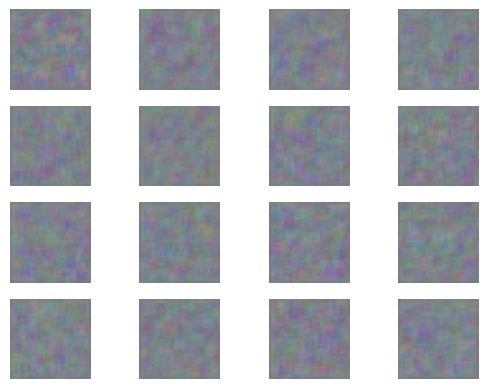

1/1 [==============================] - 0s 278ms/step


KeyboardInterrupt: ignored

In [ ]:
num_epochs=15000
batch_size=32
display_interval=2500
losses=[]


X = (X / 127.5) - 1.


valid = np.ones((batch_size, 1))


valid += 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)

for epoch in range(num_epochs):



            index = np.random.randint(0, X.shape[0], batch_size)
            images = X[index]

            #Sampling noise and generating a batch of new images
            noise = np.random.normal(0, 1, (batch_size, latent_dimensions))
            generated_images = generator.predict(noise)


            #Training the discriminator to detect more accurately
            #whether a generated image is real or fake
            discm_loss_real = discriminator.train_on_batch(images, valid)
            discm_loss_fake = discriminator.train_on_batch(generated_images, fake)
            discm_loss = 0.5 * np.add(discm_loss_real, discm_loss_fake)

            #Training the Generator

            #Training the generator to generate images
            #which pass the authenticity test
            genr_loss = combined_network.train_on_batch(noise, valid)

            #Tracking the progress
            if epoch % display_interval == 0:
                 display_images()
